# Bayesian GLMs, because life isn't always Normal 🤷‍♂️

Up until now, we've always encountered Normally-distributed data -- or at least data that could be modeled with a Normal likelihood. In our real life of statisticians, we won't always have that luxury. 

Count data for instance, can't be modeled easily with a Normal. Why? For starters, they only take positive integer values, while a Gaussian distribution is defined on the whole real line. As a result, we have to use probability distributions that more closely match our data generative process. Luckily, we have plenty at our disposal, the most well known being the Poisson and Binomial regressions.

In this notebook, we'll go through fully worked out examples of both these types of regression. We'll also show you a common circumstance where the assumptions built into these distributions fall apart in real life -- and how to remedy that.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Poisson regression, when sky is the limit

This model is inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerned with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.

We're going to work with simpler data than the original study, which will allow you to clearly see the modeling stakes. Let's load them up!

In [3]:
sneezes = pd.read_csv("../data/poisson_sneeze.csv")
sneezes

,nsneeze,alcohol,meds
0,2,0,1
1,2,0,1
2,0,0,1
3,1,0,1
4,3,0,1
...,...,...,...
3995,27,1,0
3996,33,1,0
3997,35,1,0
3998,12,1,0


+ The subject sneezes N times per day, recorded as `nsneeze (int)`. The data are aggregated per day, to yield a total count of sneezes on that day.
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as `meds (boolean)`

We assume that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increases if alcohol is consumed.

### Visualize the data and set up the model

/home/lpaz/anaconda3/envs/bayes_workshop/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


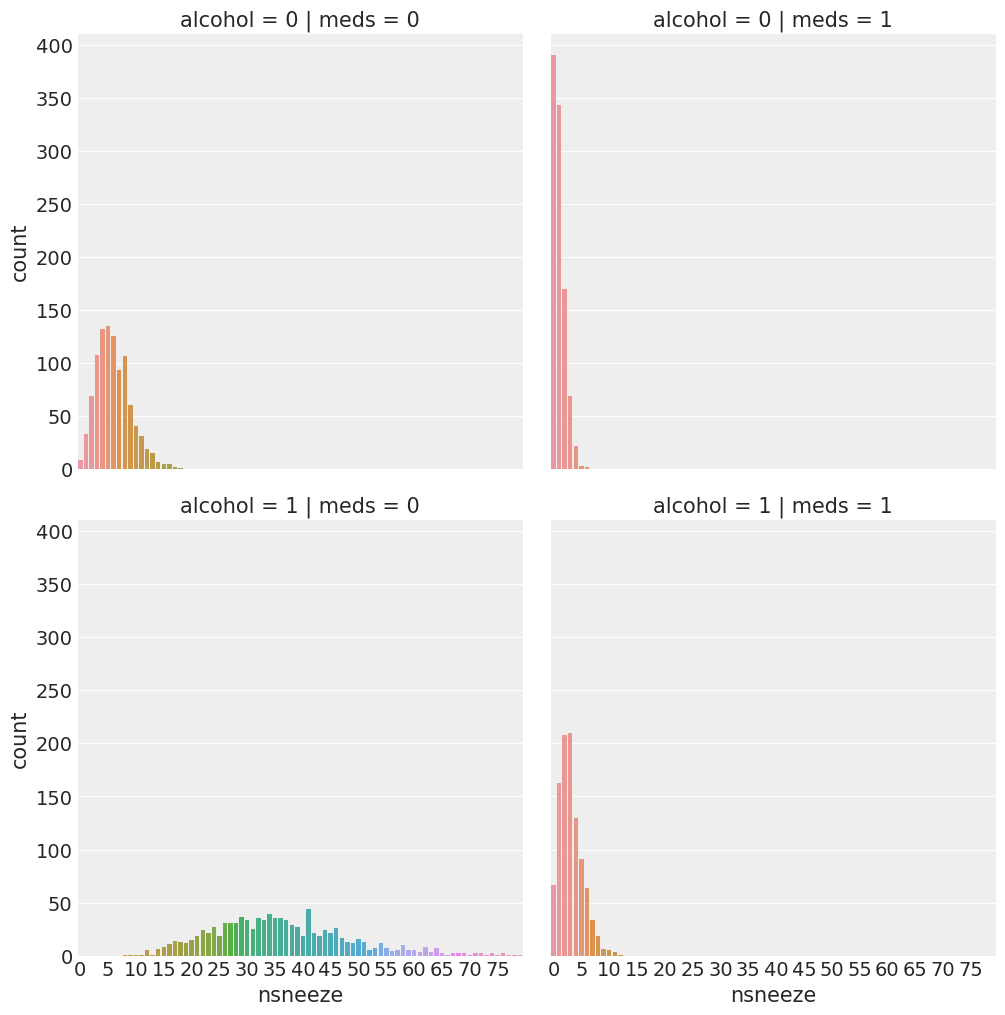

In [4]:
g = sns.catplot(x="nsneeze", col="meds", row="alcohol", data=sneezes, kind="count")

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which="both")))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

This is setting is a classical one for a Poisson likelihood: these are count data, but there is no obvious upper bound -- what's the maximum any person can sneeze per day? Hard to tell!

So, contrary to the Binomial distribution, the Poisson doesn't have a parameter for the number `n` of trials -- actually, another way of thinking about the Poisson is to view it as a Binomial with a very high, unknown `n`. If you feel lost here because you don't know about the Binomial, don't worry, we're going to get to it later; this was just a preview 😉

A nice property of the Poisson is that it's defined with only one parameter, usually called $\lambda$. Why? Because this parameter, which is both the mean and variance of the Poisson, can be interpreted as the rate of events per unit -- here, if we inferred $\lambda = 2.8$, that would mean the subject is thought to sneeze about 2.8 times per day.

In statistical terms, that means our likelihood is $$ Y_{sneeze\_count} \sim Poisson(\lambda)$$

Now, we need a prior on $\lambda$, right? Well that's where the regression part comes in: remember that we want to infer the effect of meds and alcohol on the number of sneezes. So, we can get back on our feet and use the usual regression setting we saw in the previous chapter: $$\lambda = \alpha + \beta_{meds} \, meds + \beta_{alcohol} \, alcohol$$

If we just use weakly informative Normal priors on our unknown parameters, this means we have our whole model!

$$\alpha \sim Normal(0, 5)$$

$$\beta_{meds}, \beta_{alcohol} \sim Normal(0, 1)$$

$$\lambda = \alpha + \beta_{meds} \, meds + \beta_{alcohol} \, alcohol$$

$$ Y_{sneeze\_count} \sim Poisson(\lambda)$$

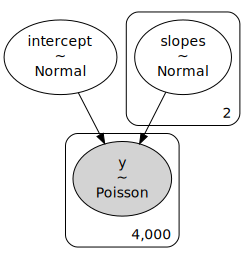

In [5]:
COORDS = {"regressor": ["meds", "alcohol"]}

with pm.Model(coords=COORDS) as m_sneeze:
    # weakly informative Normal
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")

    # define linear model
    λ = a + b[0] * sneezes.meds + b[1] * sneezes.alcohol

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=λ, observed=sneezes.nsneeze)

pm.model_to_graphviz(m_sneeze)

### Sample the model

And we now have everything to sample from our model!

In [6]:
with m_sneeze:
    trace_sneeze = pm.sample(return_inferencedata=True)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'intercept': array(0.), 'slopes': array([0., 0.])}

Initial evaluation results:
intercept   -2.53
slopes      -1.84
y            -inf
Name: Log-probability of test_point, dtype: float64

Mmmh, that's not good: PyMC didn't even start sampling. Apparently, the initial values used to instantiate the model are wrong: do you see that `-inf` log probability for `y` in the error message? This means that our likelihood has probability 0 at the starting point, which is why PyMC can't sample!

Usually, this is due to either missing values in the observed data, or a misspecification in the model (e.g using probability distributions whose support are not compatible). Here, we _know_ there are no missing values in our observations, so we probably misspecified our model 🤔

Wait! Look at the starting values: both the intercept and slopes are 0, which $\lambda$ is too, which is not possible for a Poisson -- the rate _has_ to be strictly positive (which makes sense, right? If the true rate of event is 0, you don't observed anything). And actually we didn't enforce that constraint in our model, which is probably why sampling is failing!

A classic way to enforce a positivity constraint is to use the exponential. Then our model becomes:

$$\alpha \sim Normal(0, 5)$$

$$\beta_{meds}, \beta_{alcohol} \sim Normal(0, 1)$$

$$\lambda = exp(\alpha + \beta_{meds} \, meds + \beta_{alcohol} \, alcohol)$$

$$ Y_{sneeze\_count} \sim Poisson(\lambda)$$

And, voilà! Now the model should sample:

In [7]:
with pm.Model(coords=COORDS) as m_sneeze:
    # weakly informative Normal
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")

    # define linear model
    λ = pm.math.exp(a + b[0] * sneezes.meds + b[1] * sneezes.alcohol)

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=λ, observed=sneezes.nsneeze)

    trace_sneeze = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slopes, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


Indeed! Quick sampling, no warning, no divergences 🥳

Before looking at the results, let's take a step back: the trick we used with the exponential is actually exactly how generalized linear models are defined. The exponential here is called **a link function**, and it's used to map the parameter space -- which is the whole real line, to allow for more flexible modeling and looks exactly like Normal regression -- to the outcome space -- which is usually smaller than the parameter space, as GLMs often deal with count data; here the outcome space are the positive integers. 

As a result, modeling possibilities are almost infinite: you just have to find an appropriate link function! We already saw one here, and we'll see another one later, when dealing with Binomial data.

### Checking our inferences

In the meantime, let's check if our model's results are credible. Do you remember a quick and good way to do that? Posterior predictive checks, that's right! 

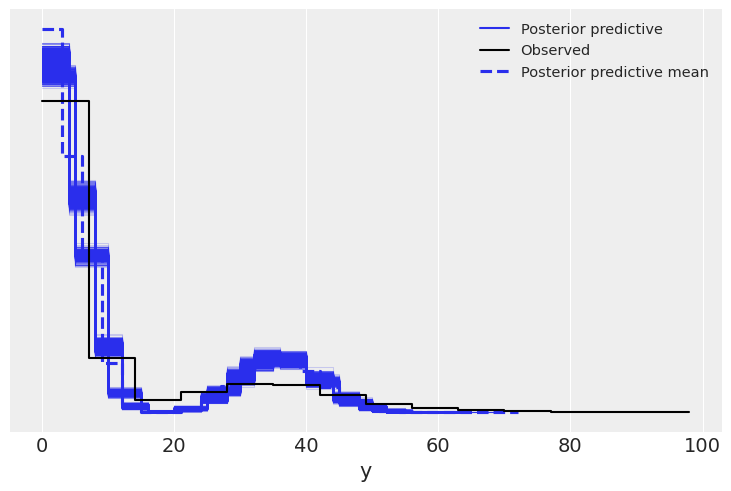

In [8]:
with m_sneeze:
    ppc = pm.sample_posterior_predictive(trace_sneeze, random_seed=RANDOM_SEED)
    trace_sneeze.extend(az.from_pymc3(posterior_predictive=ppc))
az.plot_ppc(trace_sneeze);

Well that's not looking very good, is it? The model seems to overestimate the number of days when subjects don't sneeze at all, as well as, oddly enough, those when people sneeze 30 to 50 times a day. Then, it underestimates everything in-between, including the long tail of observed values.

This behavior is quite common with Poisson regression: it often underestimates the variation in the data, simply because real data are more dispersed than our regression expects -- in these cases, data are said to be "overdispersed", although I don't really like that term: it's rather the model that is "underdispersed". This phenomenon is particularly accute with the Poisson, because its variance is mathematically constrained to be equal to its mean. So, when the data's mean and variance are not similar, a Poisson regression will tend to underestimate the true variance observed in the data.

And indeed, if you compare our data's mean and variance:

In [9]:
sneezes.groupby(["meds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
meds alcohol                    
0    0         5.996    9.557542
     1        36.006  158.450414
1    0         1.005    1.134109
     1         3.099    4.255454

Bingo! For each combination of `alcohol` and `meds`, the variance of `nsneeze` is higher than the mean.

So, you may ask, what do we do now?

## Gamma-Poisson regression, when just fish is not enough

Gamma-Poisson (aka [Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)) regression is used to do just that: model count data for which the variance is higher than the mean. The Gamma-Poisson distribution can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance. If you want more details about these models (poetically named "continuous mixture models"), I'd refer you to chapter 12 of [Richard McElreath's excellent _Statistical Rethinking_](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb).

In addition to the Poisson rate, $\lambda$, Gamma-Poisson distributions are parametrized by one strictly positive real, $\phi$, which controls the Gamma distribution. The good news is that we saw priors that fit that constraint in the previous chapter -- an exponential distribution should do fine here (don't worry, as always, if that assumption proves problematic, we can always go back and modify it):

In [10]:
with pm.Model(coords=COORDS) as m_sneeze_gp:
    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    ϕ = pm.Exponential("ϕ", 1.0)

    # linear model
    λ = pm.math.exp(a + b[0] * sneezes.meds + b[1] * sneezes.alcohol)

    ## likelihood
    y = pm.NegativeBinomial("y", mu=λ, alpha=ϕ, observed=sneezes.nsneeze)

    trace_sneeze_gp = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϕ, slopes, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


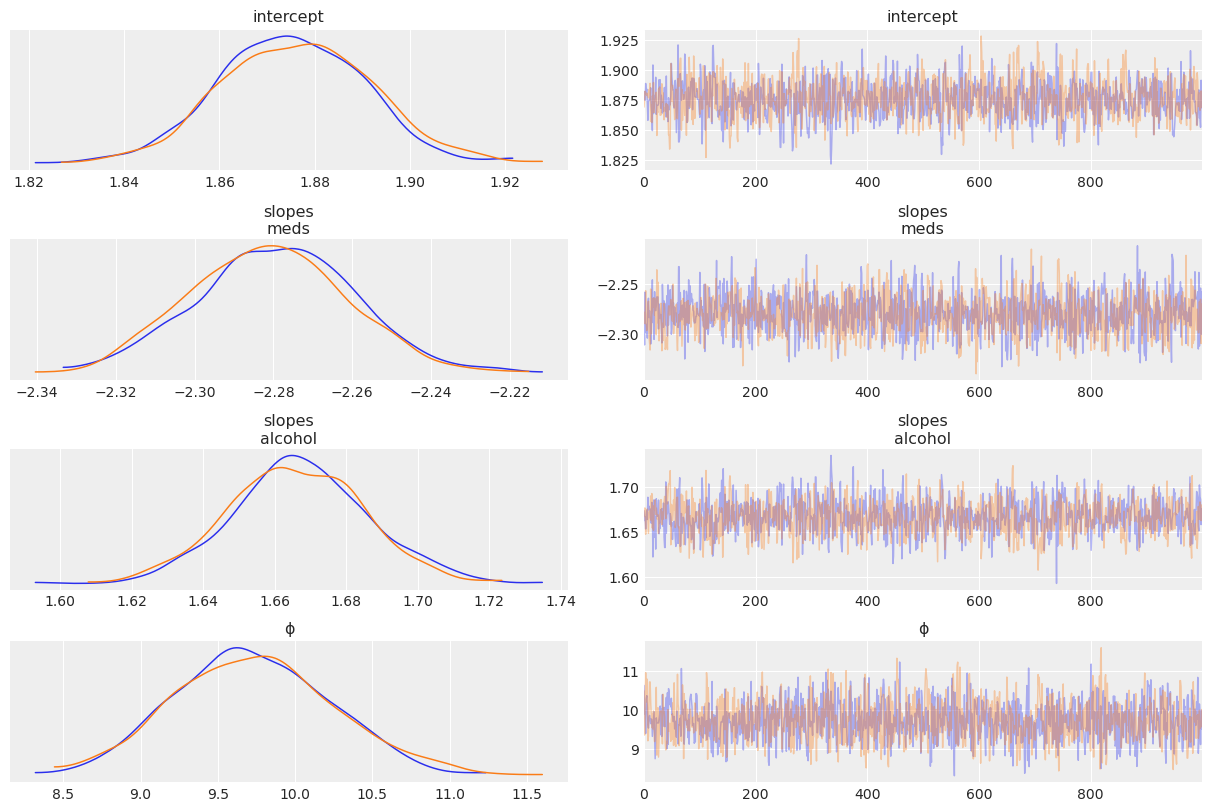

In [11]:
az.plot_trace(trace_sneeze_gp, compact=False);

Sampling went well. Now how does our posterior retrodictions look like?

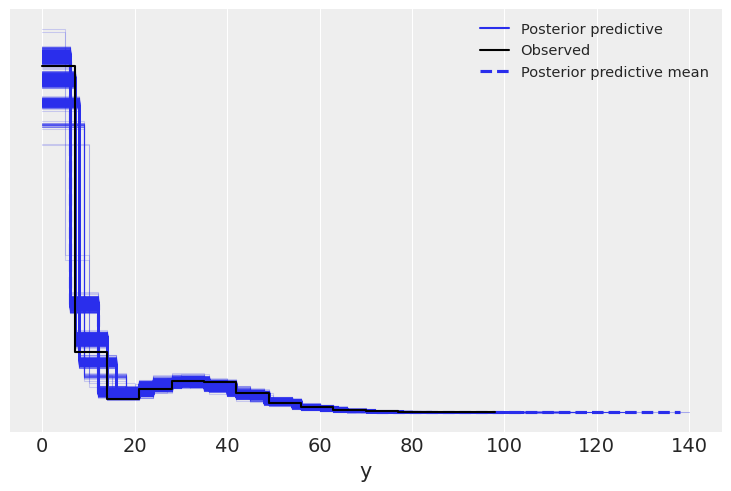

In [12]:
with m_sneeze_gp:
    ppc = pm.sample_posterior_predictive(trace_sneeze_gp, random_seed=RANDOM_SEED)
    trace_sneeze_gp.extend(az.from_pymc3(posterior_predictive=ppc))
az.plot_ppc(trace_sneeze_gp);

Much better, right? The model still has problems for very low numbers of sneezes -- probably because our predictors don't help predict the baseline number of sneezes very well. They don't really tell us anything about that, so we should probably refine our model by thinking harder about what's associated with sneezing in the absence of allergies and alcohol. That's precisely where talking to a domain expert would help a lot! From ~15 sneezes onward though, the model is doing a pretty decent job now, isn't it?

Actually, a low hanging fruit is testing whether meds and alcohol interact with each other. It's quite conceivable that the effect of meds on sneezing depends on the consumption of alcohol. This describes an interaction term, that we can simply add to our regression, by just multiplying `meds` by `alcohol`:

In [13]:
COORDS["regressor"].append("meds : alcohol")

with pm.Model(coords=COORDS) as m_sneeze_inter:
    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    ϕ = pm.Exponential("ϕ", 1.0)

    # linear model
    λ = pm.math.exp(
        a
        + b[0] * sneezes.meds
        + b[1] * sneezes.alcohol
        + b[2] * sneezes.meds * sneezes.alcohol
    )

    ## likelihood
    y = pm.NegativeBinomial("y", mu=λ, alpha=ϕ, observed=sneezes.nsneeze)

    trace_sneeze_inter = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϕ, slopes, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


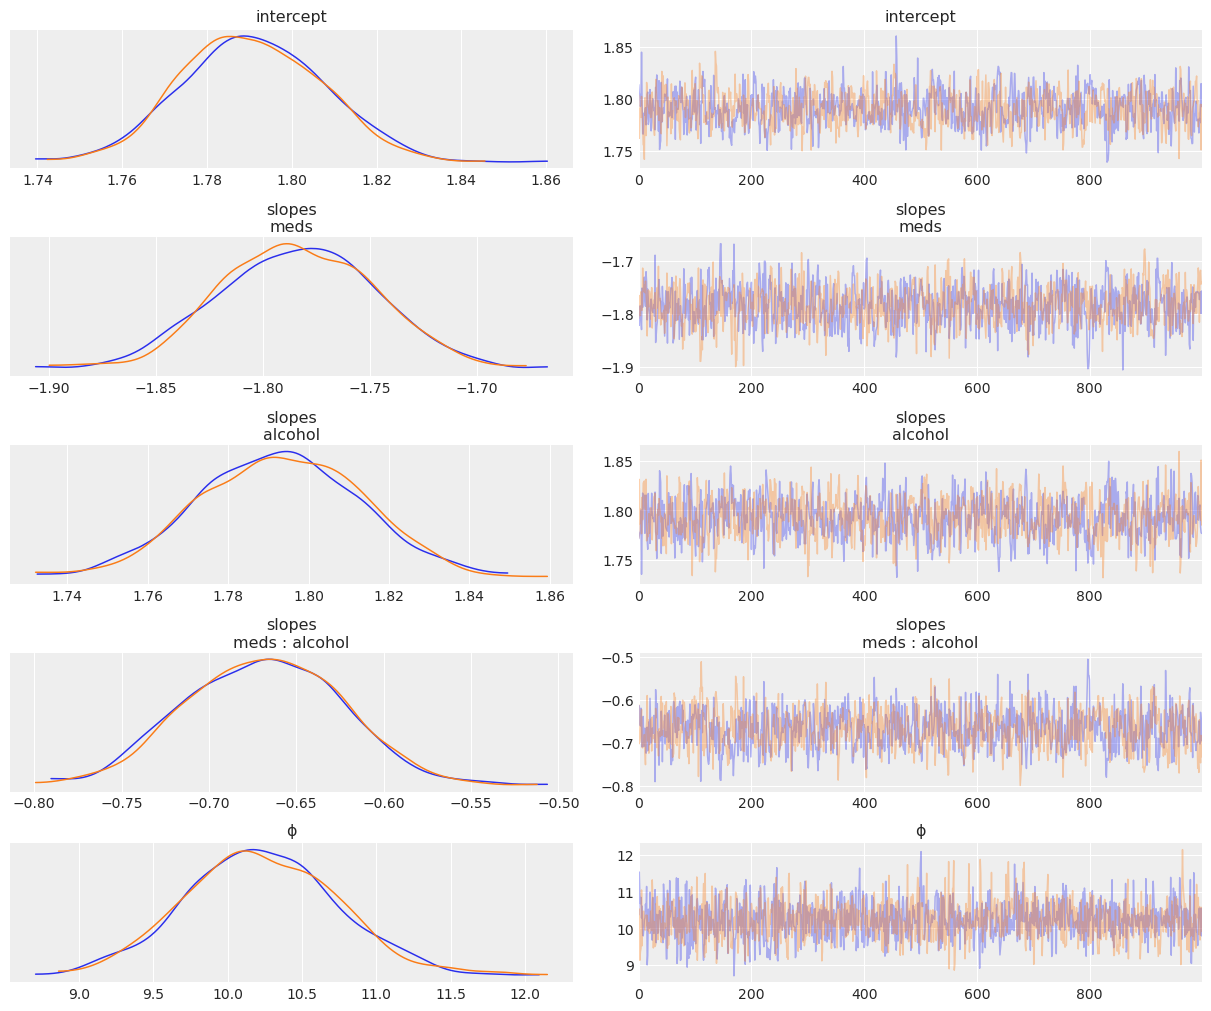

In [14]:
az.plot_trace(trace_sneeze_inter, compact=False);

We see that the slope for the interaction is reliably negative, meaning that taking meds when drinking alcohol will still tame the effects of the latter on sneezing and thus decrease the number of sneezes compared to not taking meds.

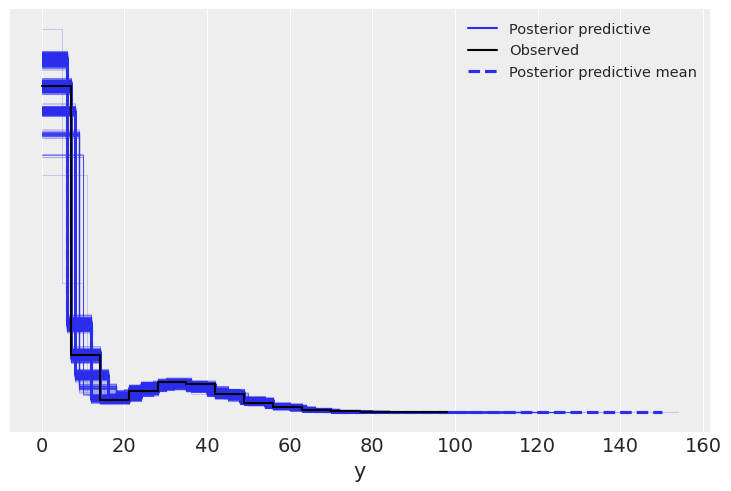

In [15]:
with m_sneeze_inter:
    ppc = pm.sample_posterior_predictive(trace_sneeze_inter, random_seed=RANDOM_SEED)
    trace_sneeze_inter.extend(az.from_pymc3(posterior_predictive=ppc))
az.plot_ppc(trace_sneeze_inter);

And indeed, we see that our model's predictions are even better than before, especially for low numbers of sneezes. But that's not all! To really see whole improvement, we will have to plot the posterior predictive distribution split by medication and alcohol consumption conditions. Let's start by plotting the predictions that the model without interaction makes:

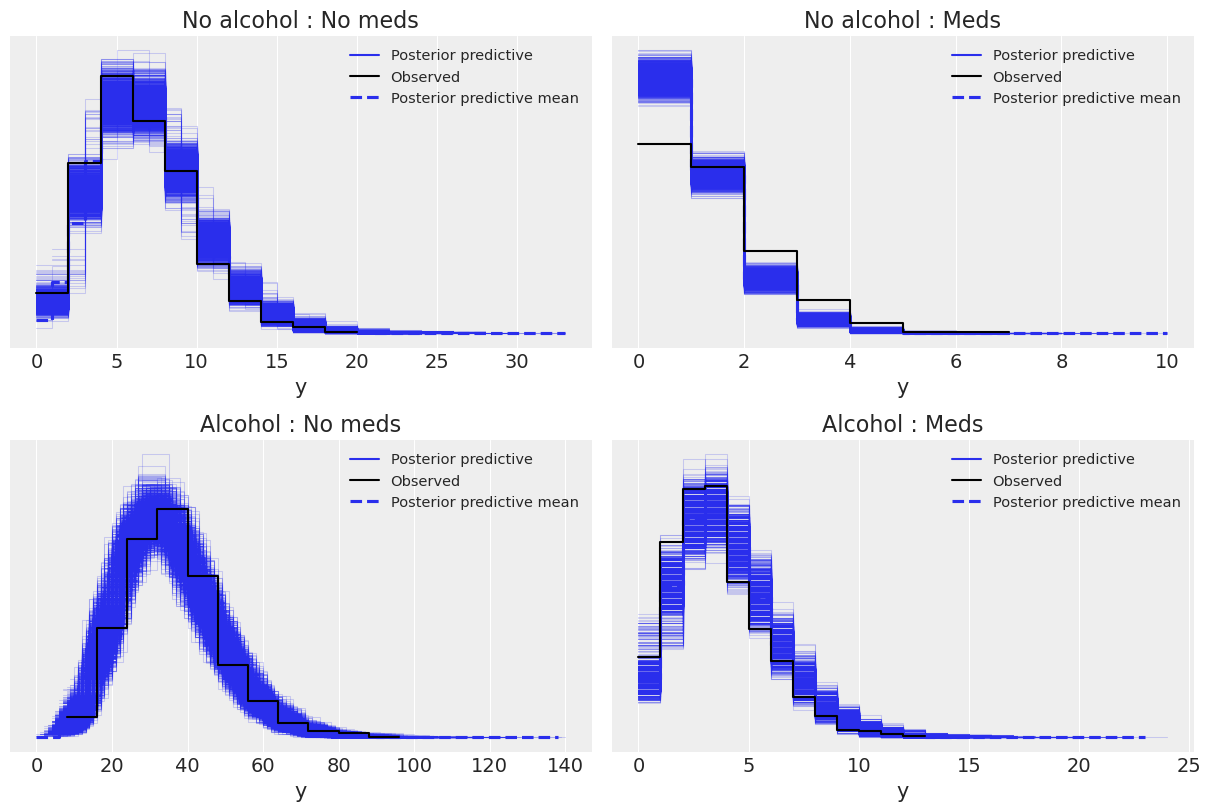

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

az.plot_ppc(
    trace_sneeze_gp,
    ax=axs[0, 0],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 0))},
    color="C0",
)
az.plot_ppc(
    trace_sneeze_gp,
    ax=axs[0, 1],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 1))},
    color="C0",
)
az.plot_ppc(
    trace_sneeze_gp,
    ax=axs[1, 0],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 0))},
    color="C0",
)
az.plot_ppc(
    trace_sneeze_gp,
    ax=axs[1, 1],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 1))},
    color="C0",
)
axs[0, 0].set_title("No alcohol : No meds")
axs[0, 1].set_title("No alcohol : Meds")
axs[1, 0].set_title("Alcohol : No meds")
axs[1, 1].set_title("Alcohol : Meds");

Here we see that our predictions are very biased when compared to the observations. The clearest example of the model's short-comings is visible in the plot for no alcohol with medication. Interestingly, all of these biases get compensated when we plot the entire posterior predictive pooling the conditions together, and that's why our full predictions look very nice.

Let's now take a look at the model with interactions:

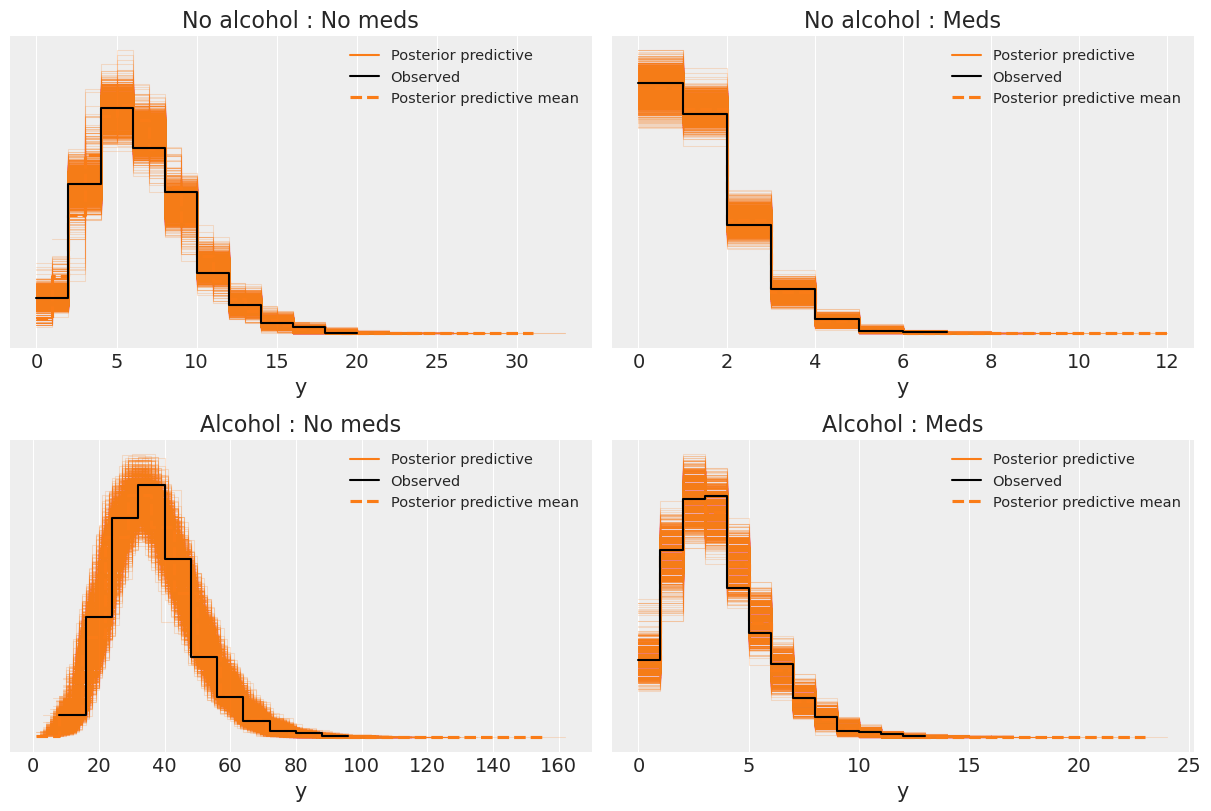

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

az.plot_ppc(
    trace_sneeze_inter,
    ax=axs[0, 0],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 0))},
    color="C1",
)
az.plot_ppc(
    trace_sneeze_inter,
    ax=axs[0, 1],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 0, sneezes.meds == 1))},
    color="C1",
)
az.plot_ppc(
    trace_sneeze_inter,
    ax=axs[1, 0],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 0))},
    color="C1",
)
az.plot_ppc(
    trace_sneeze_inter,
    ax=axs[1, 1],
    coords={"y_dim_0": np.where(np.logical_and(sneezes.alcohol == 1, sneezes.meds == 1))},
    color="C1",
)
axs[0, 0].set_title("No alcohol : No meds")
axs[0, 1].set_title("No alcohol : Meds")
axs[1, 0].set_title("Alcohol : No meds")
axs[1, 1].set_title("Alcohol : Meds");

and here we see that the prediction biases have dissappeared and we are able to predict the observations much better!

## Binomial regression

In France, presidents are elected for five years. In the meantime, lots of polls are conducted to try and gauge the president's popularity, which often drives his reelection chances. In statistics, we call that "survey data", and the fun thing about them is that are perfectly imperfect: measurements can be biased, the polling houses' sampling methods can be wrong, people answer less and less to pollsters, etc. For statisticians, this is a delight!

Here, these polls are trying to answer one main question: if a referendum were held today where people have to say whether they approve or disapprove of the president, what would be the result? In other words, polls are a noisy estimate of the president's true, latent popularity. This is a great setting for a statistical model, right?

### Show me the data!

I compiled all the popularity opinion polls for Emmanuel Macron, the current French president. Let's see what the data look like, before diving into the model:

In [16]:
polls = pd.read_csv("../data/macron_popularity.csv")
polls

,date,president,party,pollster,method,N_approve,N_disapprove,N_total,unemployment
0,2017-05-17,macron,center,Elabe,internet,450,460,910,9.2
1,2017-05-20,macron,center,Ifop,phone,603,302,905,9.2
2,2017-05-20,macron,center,Ipsos,internet,467,274,741,9.2
3,2017-05-21,macron,center,Viavoice,internet,493,302,795,9.2
4,2017-05-23,macron,center,BVA,internet,627,354,981,9.2
...,...,...,...,...,...,...,...,...,...
350,2021-01-08,macron,center,Ifop,internet,463,565,1028,7.7
351,2021-01-14,macron,center,Odoxa,internet,401,602,1003,7.7
352,2021-01-23,macron,center,Ipsos,internet,350,600,950,7.7
353,2021-01-31,macron,center,Kantar,face-to-face&internet,780,1120,1900,7.7


The most important column here is `N_approve`, the number of people who approve of Macron. What we want is a model that takes these polls as raw inputs and infers the true latent proportion of people who do approve of the president.

### Build me a model

The polls are, quite simply, realizations of a Binomial distribution: for each poll, a number $N_{total}$ of people are surveyed, and $N_{approve}$ of them say they approve of the president's job. Statistically speaking, we have $$N_{approve} \sim Binomial(N_{total}, p_{approve})$$, where $p_{approve}$ equals the proportion of people supporting the president.

So now we just need a prior over $p_{approve}$. A good prior for this usually is a Beta distribution, because its support is restricted to $[0, 1]$ -- exactly like probabilities! 

Beta distributions are parametrized by two positive reals, $\alpha$ and $\beta$. The thing is that $\alpha$ and $\beta$ usually don't have a real meaning, so it's often easier to parametrize the Beta distribution with two other parameters, $p$ and $\theta$, which roughly correspond to the mean and precision respectively: for a given $p$, a higher $\theta$ means that we are more skeptical of very weak or very strong probabilities -- those near 0 or 1.

French presidents are usually not that popular, at least compared to the US. So a mean approval around 40% seems reasonable -- we have our prior for $p$! For $\theta$, a value of 2 translates to a uniform prior over probabilities, which is not what we want -- we _know_ presidential approval never goes below 10% and above 90%. To get that, we can set $\theta = 10$. You can play around with the code below to get a sense of how the Beta family behaves:

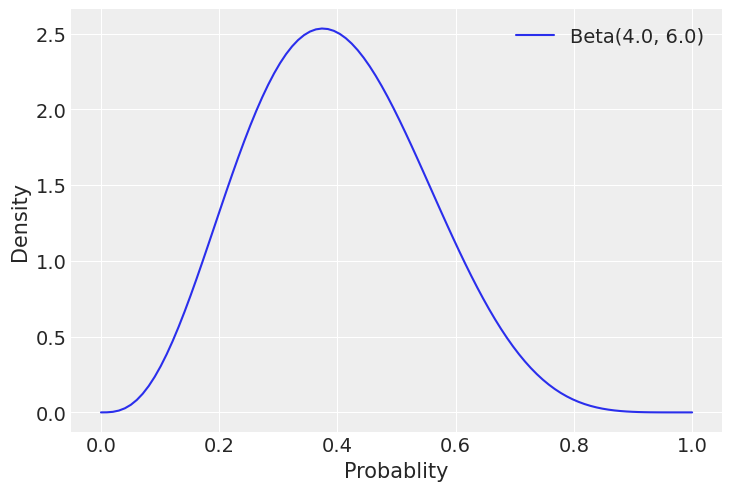

In [17]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.4
theta = 10.0

plt.plot(
    x_plot,
    np.exp(pm.Beta.dist(pbar * theta, (1 - pbar) * theta).logp(x_plot).eval()),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

Looks good right? And you can see that the mathematical link between $(p, \theta)$ and $(\alpha, \beta)$ is quite simple:

$$ \alpha = p \times \theta $$
$$ \beta = (1 - p) \times \theta $$

We now have all the parts of our (very simple, admittedly) model:

$$p_{approve} \sim Beta(4, 6)$$
$$N_{approve} \sim Binomial(N_{total}, p_{approve})$$

Let's code that up and run it in PyMC3:

In [18]:
with pm.Model() as m_raw:
    
    # write down the model here

    trace_raw = pm.sample(return_inferencedata=True)
az.summary(trace_raw, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_approve]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_approve,0.38,0.0,0.38,0.38,0.0,0.0,1488.44,2441.07,1.0


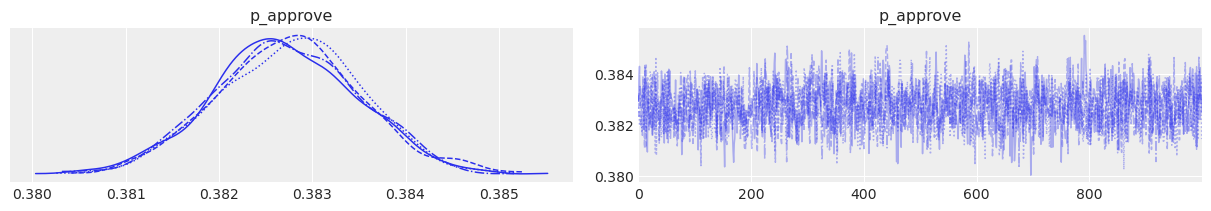

In [19]:
az.plot_trace(trace_raw);

Sampling went well, and we can see that the model is _very_ confident that Macron's popularity is around 38% (what did I tell you? That's what one calls a good prior, right? 😉): the posterior of `p_approve` basically goes from 0.380 to 0.386! It's because we have more than 300 polls, which is a lot. 

Of course, you, as a human, know that all those polls are not equal: those from 2017 should probably be discarded in 2021, but the model doesn't know that (we didn't tell it). Another reason is also that Binomial regressions in the wild tend to give overconfident estimates, for reasons similar to the Poisson, that we outlined above. If you add to that the fact that polls are noisy observations, which, again, we didn't tell the model, that's quite a lot of reasons not to trust this model a lot.

Actually, let's visualize posterior predictions of our model and see whether our skepticism is warranted:

In [ ]:
# do the posterior predictive plot here

Wow, that doesn't look good! The model is not that bad for average to high approval numbers, but it is really bad at predicting low approval numbers, clearly overestimating their frequency. It's not _that_ surprising though: this model is very simple, while approval ratings are the results of complex socio-economic interactions that evolve with time. It's mainly an excuse to learn Binomial regression, and you'll see that these data are a good show case of incremental model building.

### Adding a predictor

A first thing we can do is help our model by adding a variable that's known or suspected to be well correlated with presidential approval. One such variable is unemployment, which we actually already have in our dataset -- yeah, sometimes life throws you some free gifts like that! 

More precisely, we will use the _logarithm_ of unemployment, not the raw unemployment rate. It's because we think that what matters for citizens when they think about unemployment is its _order of magnitude_, not its absolute value. Our model now looks like that:

$$baseline \sim Normal(-0.7, 0.5)$$

$$\beta_{unemp} \sim Normal(0, 0.2)$$

$$p_{approve} = logistic(baseline + \beta_{unemp} \times log(unemp\_ data))$$

$$N_{approve} \sim Binomial(N_{total}, p_{approve})$$

#### It's all logistics!

How did I choose the priors? We'll get back to that in a minute, but first, did you notice the `logistic` link function? This has the same role as the exponential in the Poisson regression, except that the `logistic` function links the real line (here, the parameter space, where $baseline$ and $\beta_{unemp}$ live) to the $[0, 1]$ line (here, the outcome space, where $p_{approve}$ lives). Mathematically:

$$logistic(x) = \frac{1}{1 + e^{-x}}$$

Let's visualize this function to get a better understanding:

In [21]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

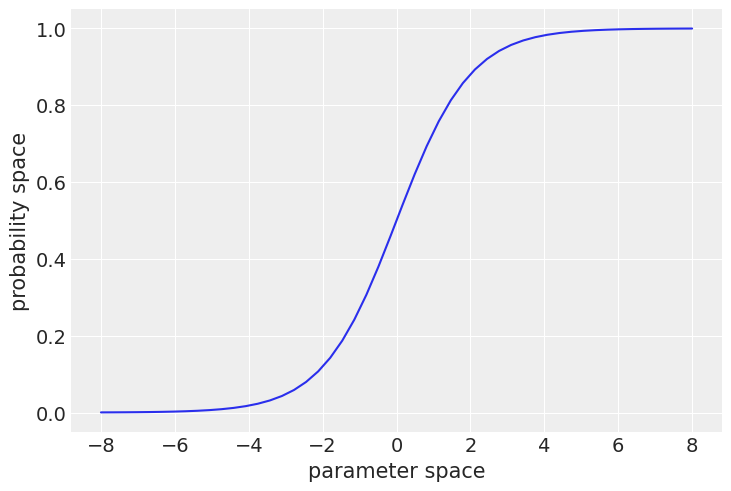

In [22]:
xvals = np.linspace(-8, 8)
plt.plot(xvals, logistic(xvals))
plt.xlabel("parameter space")
plt.ylabel("probability space");

Makes sense? If it still feels a bit fuzzy, it's perfectly normal. The more you use this function, the more you'll develop an intuition for it. For now, you can notice that 0 on the parameter space translates to a probability of 50%. Similarly, -4 is almost 0 and 4 is almost 1; -6 is _really_ 0 and 6 is _really_ 1. 

This means that the logistic strongly distorts the parameter space: only the numbers on $]-6, 6[$ have a probability different than 0 or 1. So priors that you _think_ are reasonable on the parameter space might turn out to be completely unreasonable on the probability space. In other words, **with GLMs you have to be _very_ careful when choosing priors, mainly because of the distortion of space caused by the link function**.

#### Selecting priors

We'll get back to them later, but **prior predictive checks are your friends** here -- repeat after me: "prior predictive checks are my friends!". Nonetheless, let's give you a preview here, shall we?

Our regression intercept is the baseline popularity. Imagine that we just did as usual and choose a classic $Normal(0, 10)$ prior, which usually works well for the intercept of a linear regression. What does this mean on the outcome space?

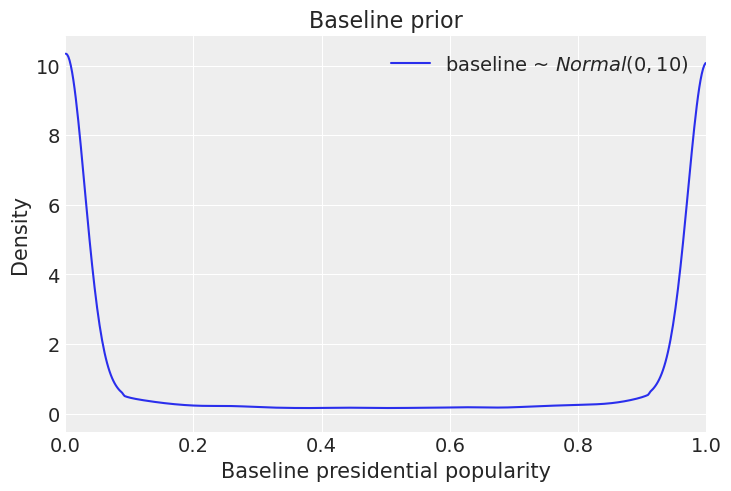

In [23]:
from scipy.special import expit as logistic

ax = az.plot_kde(
    logistic(pm.Normal.dist(0, 10).random(size=20_000)),
    label="baseline ~ $Normal(0, 10)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

Granted, those are pretty "rock on" horns 🤘 Apart from that, those priors are completely crazy, right? They actually expect the opposite of our domain knowledge! Because, when we think about it, we have quite a lot of information before seeing any polls: 50% popularity is historically high for a French president, so keeping the mean at zero (i.e $logistic(0) = 0.5$ on the outcome space) is sub-optimal. 

We can do better: we expect most presidents to have a baseline popularity between 20% and 50% -- in other words, French people rarely love their presidents but often _really_ dislike them. $Normal(-0.7, 0.5)$ looks reasonable in that regard: it expects 95% of the probability mass to be between -1.7 and 0.3, i.e $logistic(-1.7) = 15\%$ and $logistic(0.3) = 57\%$, with a mean approval of $logistic(-0.7) = 33\%$:

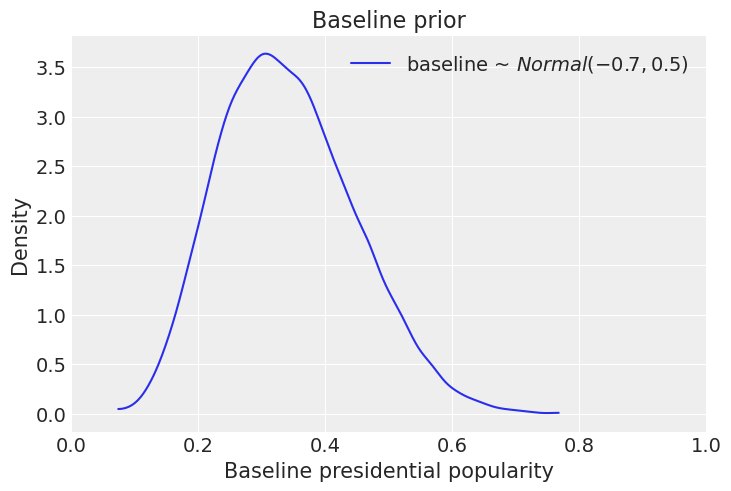

In [24]:
baseline_prior_samples = pm.Normal.dist(-0.7, 0.5).random(size=20_000)

ax = az.plot_kde(
    logistic(baseline_prior_samples),
    label="baseline ~ $Normal(-0.7, 0.5)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

Aaaah, that looks much better 🤩 

For the unemployment parameter though, we should expect a much milder effect. First, because socio-demographic variables usually have small effects in the literature. Second, because unemployment is not the only thing influencing voters' opinion of the president: there is also, notably, partisanship, which makes movements in popularity less responsive to unemployment -- if you really don't like the president, you probably need to see a very low unemployment rate before starting to credit him.

All in all, we expect the unemployment to have a small negative effect, but we're not sure. So, let's center our prior on $0$ (i.e no expected effect) and use a weakly regularizing $\sigma$ (in log-odds space): $\beta_{unemp} \sim Normal(0, 0.2)$. To see the effect of this prior, we have to plug it into the formula for our model, $p_{approve} = logistic(baseline + \beta_{unemp} \times log(unemp\_ data))$.

We just have to generate fake unemployment data. This is a good time to note that we'll standardize the real unemployment data (i.e force it to have mean 0 and standard deviation 1). Indeed that makes it easier to set our priors, and our sampler will have a better time sampling -- so, you know two 🐦 with one 💎 !

In [25]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


stdz_log_unemployment = standardize(np.log(polls.unemployment)).values

So, as the data are standardized, simulating fake unemployment between -3 and 3 is largely sufficient to cover the whole range of possible data:

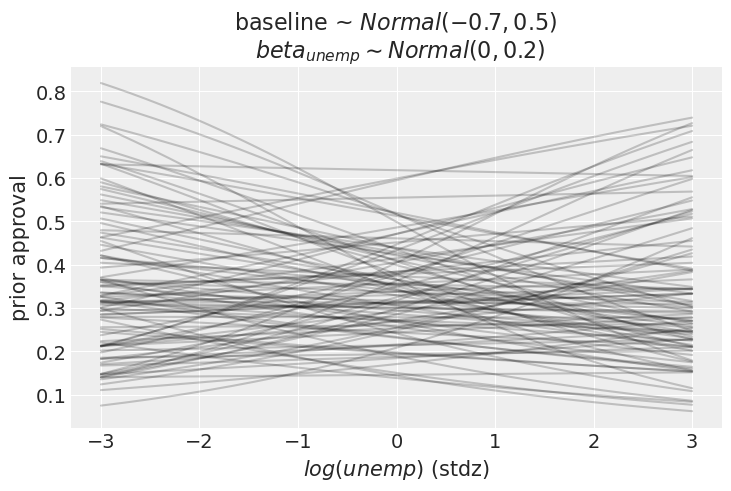

In [26]:
unemp_effect_prior_samples = pm.Normal.dist(0.0, 0.2).random(size=20_000)
fake_unemp = np.linspace(-3, 3, 200)

prior_approval = logistic(
    baseline_prior_samples[:, None] + unemp_effect_prior_samples[:, None] * fake_unemp
)

for i in range(100):
    plt.plot(fake_unemp, prior_approval[i], "k", alpha=0.2)
plt.xlabel("$log(unemp)$ (stdz)")
plt.ylabel("prior approval")
plt.title("baseline ~ $Normal(-0.7, 0.5)$ \n $beta_{unemp} \sim Normal(0, 0.2)$");

Each line is a possible relationship, according to our model's assumptions, between unemployment and latent popularity, factoring in the baseline effect. And this looks quite nice, doesn't it? It's indeed quite realistic that popularity doesn't jump around each time unemployment changes. One thing we could think of adding though is an assumption that approval probably decreases when unemployment increases. But that's good enough for now.

#### Sampling from the model

We now have everything to fire up PyMC3:

In [27]:
with pm.Model() as m_unemp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)
    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0.0, 0.2)

    p_approve = pm.math.invlogit(baseline + log_unemp_effect * stdz_log_unemployment)

    n_approve = pm.Binomial(
        "n_approve", n=polls.N_total, p=p_approve, observed=polls.N_approve
    )

    trace_unemp = pm.sample(return_inferencedata=True)

az.summary(trace_unemp, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_unemp_effect, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,-0.48,0.0,-0.49,-0.48,0.0,0.0,3467.69,2984.41,1.0
log_unemp_effect,0.15,0.0,0.14,0.15,0.0,0.0,3470.59,2647.01,1.0


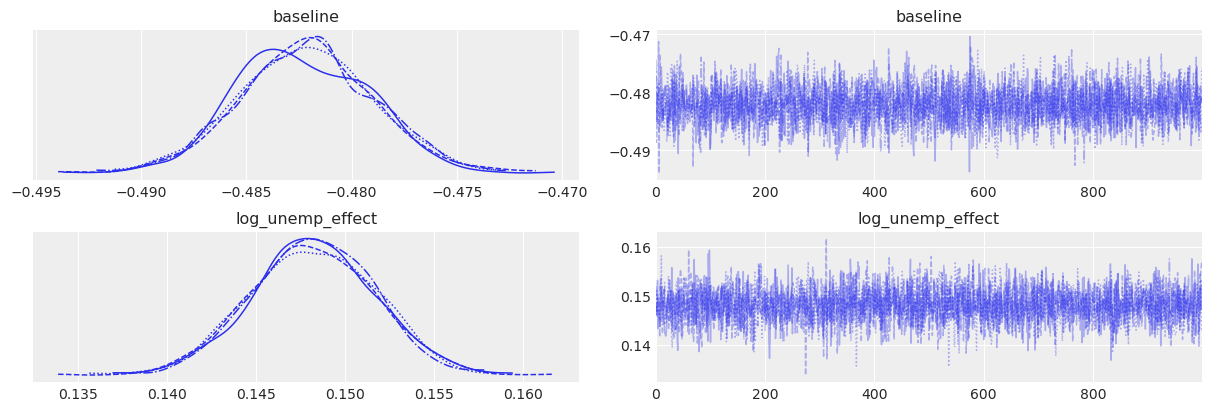

In [28]:
az.plot_trace(trace_unemp);

In [29]:
with m_unemp:
    ppc_unemp = pm.sample_posterior_predictive(trace_unemp, random_seed=RANDOM_SEED)
    trace_unemp.extend(az.from_pymc3(posterior_predictive=ppc_unemp))

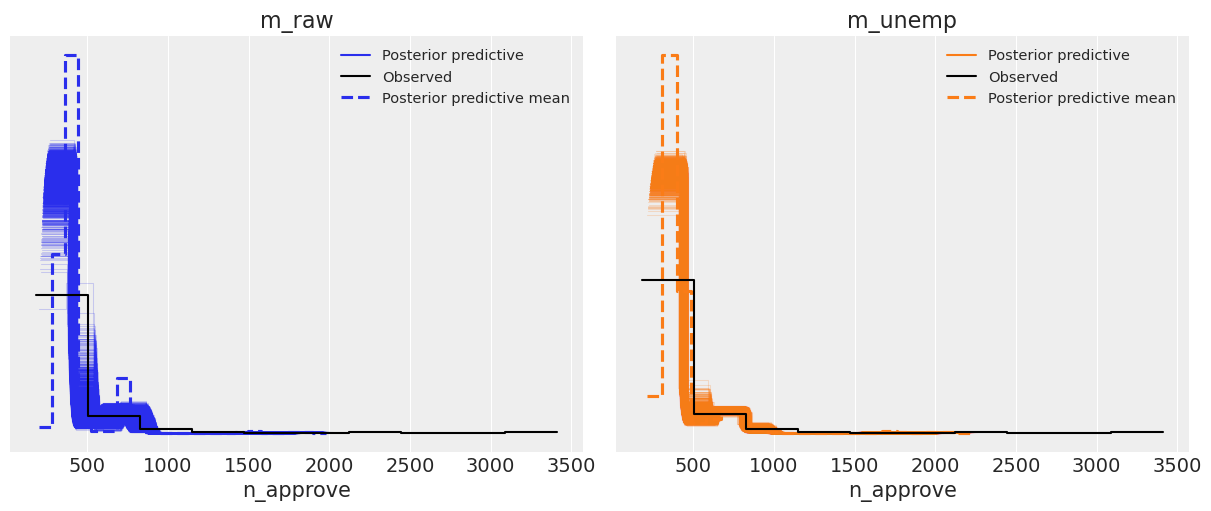

In [30]:
_, (left, right) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
az.plot_ppc(trace_raw, ax=left)
left.set_title("m_raw")
az.plot_ppc(trace_unemp, ax=right, color="C1")
right.set_title("m_unemp");

Mmmh, that looks a bit better, but not that much. The model still has troubles with low approval ratings. And yet, as you can see in the trace plot and summary above, it is still _very_ confident in its estimates. Both wrong _and_ overconfident? That's not a good combination! And it's time to tackle this overconfidence.

## Beta-Binomial regression

As we said earlier, Binomial regressions tend to give overconfident estimates, for reasons similar to the Poisson. So, as we used the Gamma-Poisson distribution to give more flexibility to the Poisson, we can use the [Beta-Binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution), which handles overdispersed data -- i.e observations that are more variable than a classic Binomial distribution would expect and can accomodate.

As a result, the Binomial probabilities are no longer fixed, but are rather random variables drawn from a common Beta distribution. So, in addition to the number of trials, $n$, Beta-Binomial distributions are parametrized by two strictly positive reals, $\alpha$ and $\beta$. That rings a bell, doesn't it? These are the same two parameters we saw for the Beta distribution above. And, of course, we're going to use the same trick and parametrize it with $p$ and $\theta$ instead.

As a result, our model becomes:

$$baseline \sim Normal(-0.7, 0.5)$$
$$\beta_{unemp} \sim Normal(0, 0.2)$$

$$p_{approve} = logistic(baseline + \beta_{unemp} \times log(unemp\_ data))$$
$$theta \sim Exponential(1) + 10$$

$$N_{approve} \sim BetaBinomial(\alpha=p_{approve} \times \theta, \: \beta=(1 - p_{approve}) \times \theta, \: N_{total})$$

The difference with our very first Binomial model is that now we need a prior for $\theta$ -- before we fixed it at 10, but now we want to actually estimate it. The good is that we already thought about this prior and decided that we want to assume that the precision is at least 10. To that end, we can use a trick and define $\theta = \tilde{\theta} + 10$, where $\tilde{\theta} \sim Exponential(1)$, which works because exponential distributions have a minimum of zero. This is exactly what you see in the latex model above.

This translates easily into PyMC3:

In [31]:
with pm.Model() as m_betabin:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)
    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0.0, 0.2)

    p_approve = pm.math.invlogit(baseline + log_unemp_effect * stdz_log_unemployment)

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    n_approve = pm.BetaBinomial(
        "n_approve",
        alpha=p_approve * theta,
        beta=(1.0 - p_approve) * theta,
        n=polls.N_total,
        observed=polls.N_approve,
    )

    trace_betabin = pm.sample(return_inferencedata=True)

az.summary(trace_betabin, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, log_unemp_effect, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,-0.49,0.02,-0.53,-0.45,0.00,0.00,5264.25,2660.72,1.0
log_unemp_effect,0.12,0.02,0.08,0.16,0.00,0.00,5045.69,2902.76,1.0
theta_offset,18.57,2.17,14.74,22.71,0.03,0.02,5098.49,2946.51,1.0


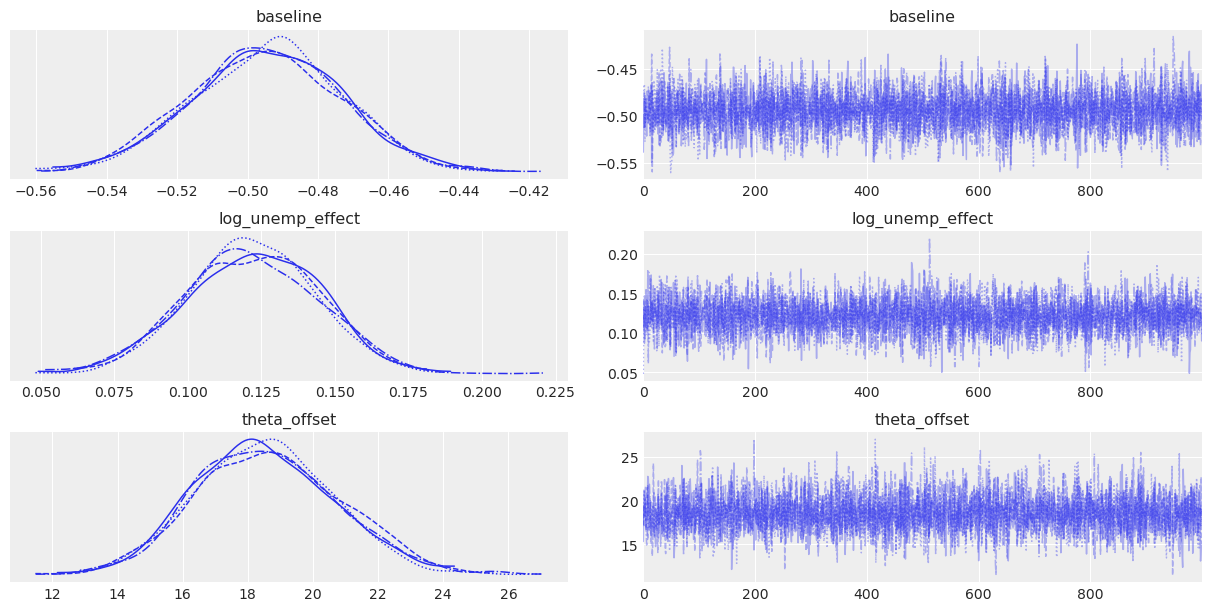

In [32]:
az.plot_trace(trace_betabin);

Note how the posterior distributions of `baseline` and `log_unemp_effect` are much wider than before -- that's already a good sign.

Now how are we doing on the predictions side?

In [ ]:
# remember how we sample from the posterior predictive distribution? Let's do that here!

In [ ]:
_, (left, middle, right) = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
az.plot_ppc(trace_raw, ax=left)
left.set_title("m_raw")
az.plot_ppc(trace_unemp, ax=middle, color="C1")
middle.set_title("m_unemp")
az.plot_ppc(trace_betabin, ax=right, color="C2")
right.set_title("m_betabin");

That's the best we've seen so far! It's still not great, but it's never going to be -- this model is still too simple. But we can clearly see in the rightmost plot that the Beta-Binomial likelihood allows our model to be much more flexible and more able to accomodate the variation in the data. 

And note that this is not cheating: polls really are noisy observations of the latent truth, so it makes sense to allow the model to estimate one Binomial probability for each poll, which is basically what a Beta-Binomial is doing.

Our predictions still aren't very useful though: true, they could have generated the observed data now, but it's also because they became much less precise. In other words, we're on target now, but it's because we're shooting in many more directions than in the vanilla Binomial regression.

### How to improve this model?

There are many avenues to explore to make our predictions more precise. We could think about adding relevant predictor variables, using polling data from previous presidents (approval works in cycle, no matter who's president, so knowing about previous presidents would help), and adding a time component (we already noticed that polls from 2017 shouldn't weigh as much as polls from 2021). This last option would also allow us to do time series predictions, which is intrinsically interesting here.

There are many different methods to implement this time component, in combination with the two other options. You can take a look at:

- [Random walks](https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.GaussianRandomWalk)
- [Gaussian Processes](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html)
- [Splines](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb)
- [Hidden Markov models](https://www.learnbayesstats.com/episode/14-hidden-markov-models-statistical-ecology-with-vianey-leos-barajas)
- [Dynamic Linear models](https://brandonwillard.github.io/dynamic-linear-models-in-theano.html)

For Gaussian Processes in particular, you can take a look at [my blog post](https://alexandorra.github.io/pollsposition_blog/popularity/macron/gaussian%20processes/polls/2021/01/18/gp-popularity.html) about this very model.

In [35]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Mar 23 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

pandas    : 1.2.3
pymc3     : 3.11.2
matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.20.1
scipy     : 1.6.0
arviz     : 0.11.2

Watermark: 2.2.0

